In [ ]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
!pip install ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.0/950.0 kB 26.2 MB/s eta 0:00:0000:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
100%|███████████████████████████████████████▉| 611M/612M [00:16<00:00, 41.2MB/s]
100%|████████████████████████████████████████| 612M/612M [00:16<00:00, 39.5MB/s]


## Data Loading

In [ ]:
folder_path = "/kaggle/working/GTSRB_Data"

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

print(f"Folder created at: {folder_path}")

Folder created at: /kaggle/working/GTSRB_Data


In [ ]:
!unzip /kaggle/working/gtsrb-german-traffic-sign.zip -d /kaggle/working/GTSRB_Data

Archive:  /kaggle/working/gtsrb-german-traffic-sign.zip
  inflating: /kaggle/working/GTSRB_Data/Meta.csv  
  inflating: /kaggle/working/GTSRB_Data/Meta/.~lock.ClassesInformation.ods#  
  inflating: /kaggle/working/GTSRB_Data/Meta/.~lock.ClassesInformationStrong.ods#  
  inflating: /kaggle/working/GTSRB_Data/Meta/0.png  
  inflating: /kaggle/working/GTSRB_Data/Meta/1.png  
  inflating: /kaggle/working/GTSRB_Data/Meta/10.png  
  inflating: /kaggle/working/GTSRB_Data/Meta/11.png  
  inflating: /kaggle/working/GTSRB_Data/Meta/12.png  
  inflating: /kaggle/working/GTSRB_Data/Meta/13.png  
  inflating: /kaggle/working/GTSRB_Data/Meta/14.png  
  inflating: /kaggle/working/GTSRB_Data/Meta/15.png  
  inflating: /kaggle/working/GTSRB_Data/Meta/16.png  
  inflating: /kaggle/working/GTSRB_Data/Meta/17.png  
  inflating: /kaggle/working/GTSRB_Data/Meta/18.png  
  inflating: /kaggle/working/GTSRB_Data/Meta/19.png  
  inflating: /kaggle/working/GTSRB_Data/Meta/2.png  
  inflating: /kaggle/working/GTS

In [ ]:
folder_path = "/kaggle/working/Checkpt_3"

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

print(f"Folder created at: {folder_path}")

Folder created at: /kaggle/working/Checkpt_3


In [ ]:
import os
print(os.listdir("/kaggle/working/GTSRB_Data"))

['Test.csv', 'Meta.csv', 'train', 'meta', 'test', 'Train', 'Train.csv', 'Test', 'Meta']


['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


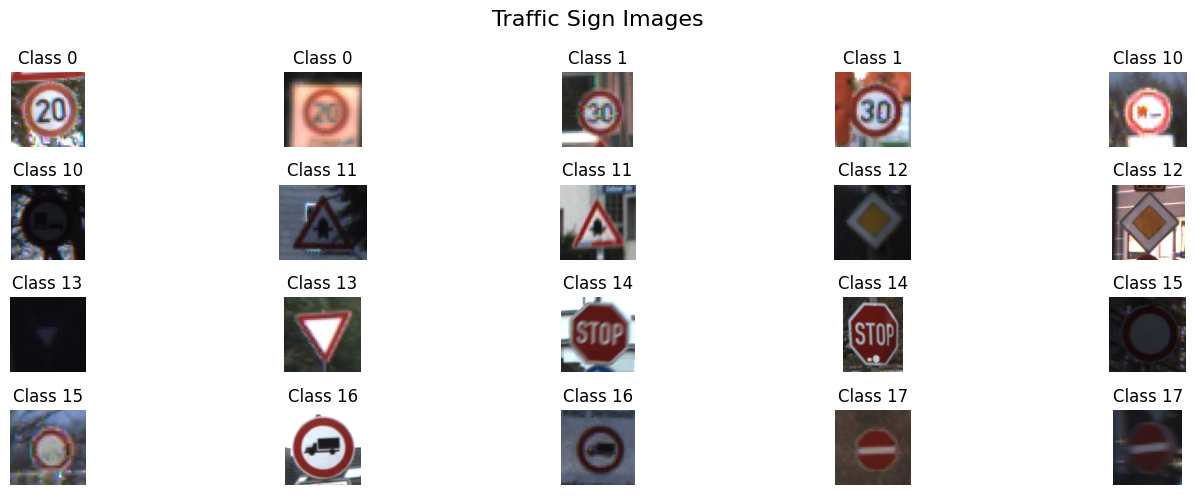

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os


dataset_path = "/kaggle/working/GTSRB_Data/Train/"


class_folders = sorted(os.listdir(dataset_path))
print(class_folders)


image_files = []


for class_folder in class_folders[:]:
    class_path = os.path.join(dataset_path, class_folder) # -------------
                                                                        #|
    if os.path.isdir(class_path):                                       #| - Here path join ka mtlb -> getting the
        for img_file in os.listdir(class_path)[:1]:                     #|   information about the whole path and
            image_files.append(os.path.join(class_path, img_file)) # ----    structuring it taki baad me sahi chale.



if len(image_files) == 0:
    print(f"No images found in {dataset_path}!")
else:
    num_images = len(image_files)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))
    fig.suptitle("Traffic Sign Images", fontsize=16)

    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, img_path in enumerate(image_files):
        img = cv2.imread(img_path)

        if img is None:
            print(f"Error loading image: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Class {os.path.basename(os.path.dirname(img_path))}")
    for j in range(i+1, len(axes)):
        fig.axes("off")
    plt.tight_layout()
    plt.show()



## Data Pre-processing and Loading the Image files

In [ ]:
data_dir = "/kaggle/working/GTSRB_Data"
train_csv_path = os.path.join(data_dir, "Train.csv")
test_csv_path = os.path.join(data_dir, "Test.csv")
train_dir = os.path.join(data_dir, "Train")
test_dir = os.path.join(data_dir, "Test")

In [ ]:
# Load Bounding Box Data
def load_bbox_data(csv_path):
    df = pd.read_csv(csv_path)
    bbox_dict = {}
    for _, row in df.iterrows():
        filename = os.path.basename(row["Path"])
        class_id = int(row["ClassId"])
        x_min, y_min, x_max, y_max = row["Roi.X1"], row["Roi.Y1"], row["Roi.X2"], row["Roi.Y2"]
        img_width, img_height = row["Width"], row["Height"]
        x_center, y_center = ((x_min + x_max) / 2) / img_width, ((y_min + y_max) / 2) / img_height
        width, height = (x_max - x_min) / img_width, (y_max - y_min) / img_height
        bbox_dict[filename] = [class_id, x_center, y_center, width, height]
    print(f"Loaded {len(bbox_dict)} bounding boxes from {csv_path}")
    return bbox_dict

train_bbox_dict = load_bbox_data(train_csv_path)
test_bbox_dict = load_bbox_data(test_csv_path)

Loaded 39209 bounding boxes from /kaggle/working/GTSRB_Data/Train.csv
Loaded 12630 bounding boxes from /kaggle/working/GTSRB_Data/Test.csv


In [ ]:
def load_images_and_labels(image_dir, bbox_dict=None, csv_path=None, is_test=False):
    """
    Loads images and labels from the dataset directory.

    Parameters:
    - image_dir (str): Path to the dataset directory.
    - bbox_dict (dict): Dictionary containing bounding boxes {filename: [class_id, x, y, w, h]}.
    - csv_path (str): Path to the CSV file for test labels.
    - is_test (bool): If True, loads test labels from CSV instead of bounding boxes.

    Returns:
    - images (numpy array): Loaded and preprocessed images.
    - labels (numpy array): Corresponding labels.
    """

    images, labels = [],[]
    valid_extensions = {".png", ".jpg", ".jpeg"}

    if is_test and csv_path:
        df = pd.read_csv(csv_path)
        filename_column = "Path" if "Path" in df.columns else "Filename"
        label_column = "ClassId"
        test_labels = dict(zip(df[filename_column].apply(os.path.basename), df[label_column]))

    for root, _, files in os.walk(image_dir):  # Recursively go through folders
        for img_file in tqdm(files, desc=f"Processing {image_dir.split('/')[-1]}"):
            img_path = os.path.join(root, img_file)

            # Skip non-image files
            if not img_file.lower().endswith(tuple(valid_extensions)):
                continue

            # Read & preprocess image
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            if img is None:
                print(f"⚠ Warning: Could not read {img_path}, skipping.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (64, 64))  # Resize to match YOLO input
            img = img / 255.0  # Normalize

            images.append(img)

            # Assign labels
            if is_test:
                label = test_labels.get(img_file, 0)  # Default class 0 if missing
            else:
                label = bbox_dict.get(img_file, [0, 0.5, 0.5, 0.5, 0.5])  # Default bbox if missing

            labels.append(label)

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.float32)

# Paths
train_dir = "/kaggle/working/GTSRB_Data/Train"
test_dir = "/kaggle/working/GTSRB_Data/Test"
test_csv_path = "/kaggle/working/GTSRB_Data/Test.csv"

# Load bounding box dictionaries for train/val
# train_bbox_dict = {}  # Load from annotation files
# val_bbox_dict = {}    # Load from annotation files

# Load Data
X_train, y_train = load_images_and_labels(train_dir, train_bbox_dict)
X_test, y_test = load_images_and_labels(test_dir, csv_path=test_csv_path, is_test=True)


# Print Shape Confirmation
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Processing Train: 0it [00:00, ?it/s]
Processing Test: 100%|██████████| 12631/12631 [00:01<00:00, 6317.54it/s]


X_train: (39209, 64, 64, 3), y_train: (39209, 5)
X_test: (12630, 64, 64, 3), y_test: (12630,)


`Splitting Training Data into - Train & Validation`

In [ ]:
from sklearn.model_selection import train_test_split

# Split Training Data (80% Train, 20% Validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Train Set: {X_train.shape[0]} images, Validation Set: {X_val.shape[0]} images")


Train Set: 31367 images, Validation Set: 7842 images


In [ ]:
np.save("/kaggle/working/Checkpt_1/X_train.npy", X_train)
np.save("/kaggle/working/Checkpt_1/y_train.npy", y_train)
np.save("/kaggle/working/Checkpt_1/X_val.npy", X_val)
np.save("/kaggle/working/Checkpt_1/y_val.npy", y_val)
np.save("/kaggle/working/Checkpt_1/X_test.npy", X_test)
np.save("/kaggle/working/Checkpt_1/y_test.npy", y_test)

## Data Augmentation

In [ ]:
X_train = np.load("/content/Checkpt_1/X_train.npy")
y_train = np.load("/content/Checkpt_1/y_train.npy")

In [ ]:
augmentations = A.Compose([
    A.Resize(64, 64, always_apply=True),
    A.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.RandomScale(scale_limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=0, p=0.5)
])

In [ ]:
def augment_and_save(images, labels):
    # os.makedirs(save_dir, exist_ok=True)
    augmented_images, augmented_labels = [], []
    for i in tqdm(range(len(images)), desc="Augmenting Images"):
        img = (images[i] * 255).astype(np.uint8)
        augmented = augmentations(image=img)
        aug_img = augmented["image"]
        aug_img = cv2.resize(aug_img, (64, 64)) / 255.0
        augmented_images.append(aug_img)
        augmented_labels.append(labels[i])
    return np.array(augmented_images), np.array(augmented_labels)

In [ ]:
X_train_aug, y_train_aug = augment_and_save(X_train, y_train)

Augmenting Images: 100%|██████████| 31367/31367 [00:13<00:00, 2279.48it/s]


In [ ]:
print(X_train_aug.shape)
print(y_train_aug.shape)

(31367, 64, 64, 3)
(31367, 5)


In [ ]:
np.save("/kaggle/working/Checkpt_2/X_train_aug.npy", X_train_aug)
np.save("/kaggle/working/Checkpt_2/y_train_aug.npy", y_train_aug)

## Converting Data To Yolo Format

In [ ]:
y_train = np.load("/kaggle/working/Checkpt_1/y_train.npy")
y_train_aug = np.load("/kaggle/working/Checkpt_2/y_train_aug.npy")
print(f"Loaded Labels: y_train: {y_train.shape}, y_train_aug: {y_train_aug.shape}")

Loaded Labels: y_train: (31367, 5), y_train_aug: (31367, 5)


`CREATING A STRUCTURED DIRECTORY - FOR SAVING THE DATA FOR MODEL BUILDING`

In [ ]:

# Define folder path
folder_path = "/kaggle/working/Checkpt_3"

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

print(f"Folder created at: {folder_path}")

Folder created at: /kaggle/working/Checkpt_3


In [ ]:
source_folder = "/kaggle/input/datapt-2/"
destination_folder = "/kaggle/working/Checkpt_2"

# Create destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Copy all files
for filename in os.listdir(source_folder):
    shutil.copy(os.path.join(source_folder, filename), os.path.join(destination_folder, filename))

print("All files copied successfully!")

All files copied successfully!


In [ ]:
#CREATING A STRUCTURED FOLDER FOR STORING IMAGE AND LABEL DATA

yolo_dataset_dir = "/kaggle/working/YOLO_Dataset"
# IMAGES
train_img_dir = os.path.join(yolo_dataset_dir, "images/train")
val_img_dir = os.path.join(yolo_dataset_dir, "images/val")
test_img_dir = os.path.join(yolo_dataset_dir, "images/test")
# LABELS
train_label_dir = os.path.join(yolo_dataset_dir, "labels/train")
val_label_dir = os.path.join(yolo_dataset_dir, "labels/val")

# Create required directories
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

In [ ]:
# Load Data
X_train = np.load("/kaggle/working/Checkpt_1/X_train.npy")
y_train = np.load("/kaggle/working/Checkpt_1/y_train.npy")
X_val = np.load("/kaggle/working/Checkpt_1/X_val.npy")
y_val = np.load("/kaggle/working/Checkpt_1/y_val.npy")
X_test = np.load("/kaggle/working/Checkpt_1/X_test.npy")
y_test = np.load("/kaggle/working/Checkpt_1/y_test.npy")
X_train_aug = np.load("/kaggle/working/Checkpt_2/X_train_aug.npy")
y_train_aug = np.load("/kaggle/working/Checkpt_2/y_train_aug.npy")

In [ ]:
# yolo_labels_dir = "/kaggle/working/YOLO_Dataset/labels/train/"
# os.makedirs(yolo_labels_dir, exist_ok=True)

# Function to save labels in YOLO format
# def save_yolo_labels(y_labels, prefix="train_"):
#     for i, label in tqdm(enumerate(y_labels), desc=f"Saving {prefix} labels"):
#         class_id, x_center, y_center, width, height = label
#         label_file = os.path.join(yolo_labels_dir, f"{prefix}{i:04d}.txt")  # 0001.txt format

#         with open(label_file, "w") as f:
#             f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# # Convert and Save Labels
# save_yolo_labels(y_train, prefix="train_")
# save_yolo_labels(y_train_aug, prefix="aug_train_")

# print("YOLO labels saved successfully!")
checkpt_dir = "/kaggle/working/Checkpt_3"
os.makedirs(checkpt_dir, exist_ok=True)
def convert_and_save_yolo(labels, save_dir, npy_path, prefix="train_"):
    yolo_labels = []
    for i, label in enumerate(labels):
        class_id, x_center, y_center, width, height = label
        yolo_labels.append([class_id, x_center, y_center, width, height])
        label_file = os.path.join(save_dir, f"{prefix}{i}.txt")
        with open(label_file, "w") as f:
            f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
    np.save(npy_path, np.array(yolo_labels, dtype=np.float32))


convert_and_save_yolo(y_train, train_label_dir, os.path.join(checkpt_dir, "y_train_yolo.npy"), prefix="train_")
convert_and_save_yolo(y_train_aug, train_label_dir, os.path.join(checkpt_dir, "y_train_aug_yolo.npy"), prefix="aug_train_")
convert_and_save_yolo(y_val, val_label_dir, os.path.join(checkpt_dir, "y_val_yolo.npy"), prefix="val_")

print(f"Saved {len(y_train) + len(y_train_aug)} training labels and {len(y_val)} validation labels in YOLO format & `.npy` for safety!")

Saved 62734 training labels and 7842 validation labels in YOLO format & `.npy` for safety!


In [ ]:
# np.save("/kaggle/working/Checkpt_3/y_train_yolo.npy", y_train)
# np.save("/kaggle/working/Checkpt_3/y_train_aug_yolo.npy", y_train_aug)

`Moving the Files to the Structure Directory`

In [ ]:
train_image_dir = "/kaggle/working/YOLO_Dataset/images/train/"
os.makedirs(train_image_dir, exist_ok=True)

In [ ]:
for i in tqdm(range(len(X_train)), desc="Saving Train Images"):
    img = (X_train[i] * 255).astype(np.uint8)  # Convert from float [0,1] to uint8 [0,255]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR (OpenCV format)

    img_filename = os.path.join(train_image_dir, f"train_{i:05d}.png")  # Unique filename
    cv2.imwrite(img_filename, img)
print("DONE")

Saving Train Images: 100%|██████████| 31367/31367 [00:09<00:00, 3169.75it/s]

DONE


In [ ]:
X_train_aug = np.load("/kaggle/working/Checkpt_2/X_train_aug.npy")

# Save each augmented image
for i in tqdm(range(len(X_train_aug)), desc="Saving Augmented Train Images"):
    img = (X_train_aug[i] * 255).astype(np.uint8)  # Convert from float [0,1] to uint8 [0,255]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR (OpenCV format)

    img_filename = os.path.join(train_image_dir, f"aug_train_{i:05d}.png")  # Unique filename
    cv2.imwrite(img_filename, img)

print("DONE")

Saving Augmented Train Images: 100%|██████████| 31367/31367 [00:09<00:00, 3182.66it/s]

DONE


In [ ]:
val_image_dir = "/kaggle/working/YOLO_Dataset/images/val/"
os.makedirs(val_image_dir, exist_ok=True)

In [ ]:
X_val = np.load("/kaggle/working/Checkpt_1/X_val.npy")

# Save each validation image
for i in tqdm(range(len(X_val)), desc="Saving Validation Images"):
    img = (X_val[i] * 255).astype(np.uint8)  # Convert from float [0,1] to uint8 [0,255]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR (OpenCV format)

    img_filename = os.path.join(val_image_dir, f"val_{i:05d}.png")  # Unique filename
    cv2.imwrite(img_filename, img)

print("DONE")

Saving Validation Images: 100%|██████████| 7842/7842 [00:02<00:00, 3238.41it/s]

DONE


In [ ]:
test_image_dir = "/kaggle/working/YOLO_Dataset/images/test/"
os.makedirs(test_image_dir, exist_ok=True)

In [ ]:
X_test = np.load("/kaggle/working/Checkpt_1/X_test.npy")

# Save each test image
for i in tqdm(range(len(X_test)), desc="Saving Test Images"):
    img = (X_test[i] * 255).astype(np.uint8)  # Convert from float [0,1] to uint8 [0,255]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR (OpenCV format)

    img_filename = os.path.join(test_image_dir, f"test_{i:05d}.png")  # Unique filename
    cv2.imwrite(img_filename, img)

print("DONE")

Saving Test Images: 100%|██████████| 12630/12630 [00:03<00:00, 3219.56it/s]

DONE


In [ ]:
import os

# Define dataset directories
dataset_path = "/kaggle/working/YOLO_Dataset/images"

# Count images in each subdirectory
train_count = len(os.listdir(os.path.join(dataset_path, "train")))
val_count = len(os.listdir(os.path.join(dataset_path, "val")))
test_count = len(os.listdir(os.path.join(dataset_path, "test")))

print(f"Image Counts:")
print(f"Train: {train_count} images")
print(f"Validation: {val_count} images")
print(f"Test: {test_count} images")

Image Counts:
Train: 62734 images
Validation: 7842 images
Test: 12630 images


In [ ]:
# Define label directories
label_path = "/kaggle/working/YOLO_Dataset/labels"

# Count label files
train_labels = len(os.listdir(os.path.join(label_path, "train")))
val_labels = len(os.listdir(os.path.join(label_path, "val")))
# test_labels = len(os.listdir(os.path.join(label_path, "test")))

print(f"Label Counts:")
print(f"Train Labels: {train_labels}")
print(f"Validation Labels: {val_labels}")
# print(f"Test Labels: {test_labels}")


Label Counts:
Train Labels: 62734
Validation Labels: 7842


-----------------------------------

In [ ]:
y_val = np.load("/kaggle/working/Checkpt_1/y_val.npy", allow_pickle=True)

print(f"🔍 First 5 Labels: {y_val[:5]}")
print(f"✅ Total Labels in y_val.npy: {len(y_val)}")

🔍 First 5 Labels: [[         17         0.5         0.5        0.75      0.7561]
 [         16         0.5         0.5      0.7619     0.77778]
 [          6         0.5         0.5     0.71429     0.72973]
 [         30         0.5         0.5     0.72973     0.72222]
 [         40         0.5         0.5     0.70732     0.70732]]
✅ Total Labels in y_val.npy: 7842


In [ ]:
import numpy as np

y_val = np.load("/kaggle/working/Checkpt_1/y_val.npy", allow_pickle=True)

print(f"✅ y_val Shape: {y_val.shape}")
print(f"✅ First 5 Labels:\n", y_val[:5])

✅ y_val Shape: (7842, 5)
✅ First 5 Labels:
 [[         17         0.5         0.5        0.75      0.7561]
 [         16         0.5         0.5      0.7619     0.77778]
 [          6         0.5         0.5     0.71429     0.72973]
 [         30         0.5         0.5     0.72973     0.72222]
 [         40         0.5         0.5     0.70732     0.70732]]


In [ ]:
import shutil

folder_path = "/kaggle/working/YOLO_Dataset/labels/val/"

# Remove the entire folder and its contents
shutil.rmtree(folder_path)

print("Folder deleted successfully!")

Folder deleted successfully!


In [ ]:
import numpy as np
import os
from tqdm import tqdm

# Define validation labels directory
val_label_dir = "/kaggle/working/YOLO_Dataset/labels/val/"
os.makedirs(val_label_dir, exist_ok=True)

# Load validation labels
y_val = np.load("/kaggle/working/Checkpt_1/y_val.npy", allow_pickle=True)

# Save each label correctly
for i, label_data in tqdm(enumerate(y_val), desc="Saving Validation Labels"):
    filename = os.path.join(val_label_dir, f"val_{i:05d}.txt")

    with open(filename, "w") as f:
        class_id, x_center, y_center, width, height = map(float, label_data)  # Convert to float
        f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

print(f"✅ Successfully saved {len(y_val)} validation labels!")


Saving Validation Labels: 7842it [00:00, 19497.22it/s]

✅ Successfully saved 7842 validation labels!


In [ ]:
val_images = {img.split('.')[0] for img in os.listdir(val_image_dir)}
val_labels = {lbl.split('.')[0] for lbl in os.listdir(val_label_dir)}

missing_labels = val_images - val_labels
missing_images = val_labels - val_images

print(f"✅ Validation Images: {len(val_images)}")
print(f"✅ Validation Labels: {len(val_labels)}")

if not missing_labels and not missing_images:
    print("🎉 All filenames now match correctly!")
else:
    print("⚠ There are still mismatches. Double-check naming formats.")

✅ Validation Images: 7842
✅ Validation Labels: 7842
🎉 All filenames now match correctly!


In [ ]:
!rm /kaggle/working/YOLO_Dataset/labels/val.cache

___________________________

In [ ]:
yaml_content = """train: /kaggle/working/YOLO_Dataset/images/train/
val: /kaggle/working/YOLO_Dataset/images/val/
test: /kaggle/working/YOLO_Dataset/images/test/

nc: 43
names: ["Speed limit (20km/h)", "Speed limit (30km/h)", "Speed limit (50km/h)",
        "Speed limit (60km/h)", "Speed limit (70km/h)", "Speed limit (80km/h)",
        "End of speed limit (80km/h)", "Speed limit (100km/h)", "Speed limit (120km/h)",
        "No passing", "No passing for vehicles over 3.5 metric tons", "Right-of-way at intersection",
        "Priority road", "Yield", "Stop", "No vehicles", "Vehicles over 3.5 metric tons prohibited",
        "No entry", "General caution", "Dangerous curve to the left", "Dangerous curve to the right",
        "Double curve", "Bumpy road", "Slippery road", "Road narrows on the right", "Road work",
        "Traffic signals", "Pedestrians", "Children crossing", "Bicycles crossing", "Beware of ice/snow",
        "Wild animals crossing", "End of all speed and passing limits", "Turn right ahead", "Turn left ahead",
        "Ahead only", "Go straight or right", "Go straight or left", "Keep right", "Keep left",
        "Roundabout mandatory", "End of no passing", "End of no passing by vehicles over 3.5 metric tons"]
"""

# Save YAML file
yaml_path = "/kaggle/working/data.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print("DONE at:", yaml_path)


DONE at: /kaggle/working/data.yaml


## Model Training

In [ ]:
# !pip install ultralytics
import ultralytics
from ultralytics import YOLO
model = YOLO("yolov8s.pt")
model.train(data="/kaggle/working/data.yaml", epochs=50, imgsz=64, batch=32, device="cuda", patience=10)

Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=10, batch=32, imgsz=64, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

train: Scanning /kaggle/working/YOLO_Dataset/labels/train.cache... 42734 images, 20000 backgrounds, 0 corrupt: 100%|██████████| 62734/62734 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/YOLO_Dataset/labels/val... 7842 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7842/7842 [00:05<00:00, 1321.12it/s]


val: New cache created: /kaggle/working/YOLO_Dataset/labels/val.cache
Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 64 train, 64 val
Using 4 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.494G     0.9954      2.484      1.083         17         64: 100%|██████████| 1961/1961 [02:43<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:22<00:00,  5.41it/s]


                   all       7842       7842      0.805       0.76      0.846      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.494G     0.7845      1.451     0.9753         22         64: 100%|██████████| 1961/1961 [02:40<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:21<00:00,  5.82it/s]


                   all       7842       7842      0.831      0.908      0.911      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.494G     0.7844      1.412     0.9707         19         64: 100%|██████████| 1961/1961 [02:32<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.86it/s]


                   all       7842       7842      0.837      0.837      0.899      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.494G     0.7532      1.365      0.965         26         64: 100%|██████████| 1961/1961 [02:33<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.90it/s]


                   all       7842       7842      0.894      0.945      0.939      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.494G     0.6912      1.257     0.9502         28         64: 100%|██████████| 1961/1961 [02:31<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.94it/s]

                   all       7842       7842      0.906       0.97      0.944       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.494G     0.6571      1.188     0.9426         23         64: 100%|██████████| 1961/1961 [02:36<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:21<00:00,  5.72it/s]

                   all       7842       7842      0.899       0.96      0.943      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.494G     0.6377      1.155     0.9387         31         64: 100%|██████████| 1961/1961 [02:36<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:21<00:00,  5.70it/s]


                   all       7842       7842      0.901      0.963      0.946      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.494G     0.6206      1.125     0.9363         28         64: 100%|██████████| 1961/1961 [02:37<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.86it/s]

                   all       7842       7842      0.939      0.958      0.968      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.494G      0.608      1.103     0.9339         24         64: 100%|██████████| 1961/1961 [02:34<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.02it/s]

                   all       7842       7842      0.925      0.973      0.967      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.494G     0.5979      1.086     0.9303         25         64: 100%|██████████| 1961/1961 [02:34<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.89it/s]

                   all       7842       7842      0.926      0.972      0.963      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.494G     0.5882      1.076     0.9293         21         64: 100%|██████████| 1961/1961 [02:32<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.01it/s]

                   all       7842       7842      0.939      0.973      0.973      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.494G     0.5789      1.058     0.9278         27         64: 100%|██████████| 1961/1961 [02:33<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.98it/s]

                   all       7842       7842      0.945      0.969      0.975      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.494G     0.5721      1.042     0.9255         28         64: 100%|██████████| 1961/1961 [02:35<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.94it/s]

                   all       7842       7842      0.954      0.965      0.978      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.494G     0.5686      1.038     0.9252         28         64: 100%|██████████| 1961/1961 [02:37<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.97it/s]

                   all       7842       7842      0.942      0.981      0.978      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.494G     0.5624       1.03     0.9236         30         64: 100%|██████████| 1961/1961 [02:32<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.06it/s]

                   all       7842       7842       0.95      0.973       0.98        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.494G     0.5541      1.015     0.9225         25         64: 100%|██████████| 1961/1961 [02:30<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.03it/s]

                   all       7842       7842      0.954      0.977      0.982      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.494G     0.5499      1.007      0.921         24         64: 100%|██████████| 1961/1961 [02:33<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.03it/s]


                   all       7842       7842      0.967      0.969      0.984      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.494G      0.547      1.007     0.9209         30         64: 100%|██████████| 1961/1961 [02:31<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.99it/s]

                   all       7842       7842      0.967      0.972      0.984      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.494G     0.5432     0.9954     0.9204         30         64: 100%|██████████| 1961/1961 [02:31<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.02it/s]

                   all       7842       7842      0.969       0.97      0.985      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.494G     0.5415     0.9898     0.9198         21         64: 100%|██████████| 1961/1961 [02:32<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.99it/s]

                   all       7842       7842      0.968      0.972      0.985      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.494G     0.5354     0.9823     0.9186         30         64: 100%|██████████| 1961/1961 [02:32<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.01it/s]

                   all       7842       7842      0.969      0.973      0.986       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.494G     0.5305     0.9734     0.9178         28         64: 100%|██████████| 1961/1961 [02:32<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.02it/s]

                   all       7842       7842      0.974      0.973      0.987       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.494G      0.528     0.9724     0.9168         20         64: 100%|██████████| 1961/1961 [02:34<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.01it/s]

                   all       7842       7842      0.975      0.974      0.988      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.494G     0.5238     0.9609      0.917         26         64: 100%|██████████| 1961/1961 [02:31<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.06it/s]

                   all       7842       7842      0.975      0.976      0.988      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.494G     0.5214     0.9571     0.9156         34         64: 100%|██████████| 1961/1961 [02:32<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.98it/s]

                   all       7842       7842      0.976      0.978      0.988      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.494G     0.5182      0.954     0.9153         20         64: 100%|██████████| 1961/1961 [02:32<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.02it/s]

                   all       7842       7842      0.976      0.979      0.989      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.494G     0.5136     0.9509     0.9138         24         64: 100%|██████████| 1961/1961 [02:32<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.94it/s]

                   all       7842       7842      0.976       0.98      0.989      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.494G     0.5132     0.9416     0.9143         22         64: 100%|██████████| 1961/1961 [02:33<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.99it/s]

                   all       7842       7842      0.978       0.98      0.989      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.494G     0.5076     0.9414     0.9139         18         64: 100%|██████████| 1961/1961 [02:33<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.02it/s]

                   all       7842       7842      0.981      0.981      0.989      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.494G     0.5058     0.9338     0.9128         29         64: 100%|██████████| 1961/1961 [02:33<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.97it/s]

                   all       7842       7842      0.982      0.983       0.99      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.494G     0.5019     0.9248      0.912         25         64: 100%|██████████| 1961/1961 [02:33<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.96it/s]

                   all       7842       7842      0.982      0.983       0.99      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.494G     0.4986     0.9239     0.9113         19         64: 100%|██████████| 1961/1961 [02:33<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.00it/s]

                   all       7842       7842      0.983      0.983      0.991      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.494G     0.4953       0.92     0.9118         20         64: 100%|██████████| 1961/1961 [02:32<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.95it/s]

                   all       7842       7842      0.984      0.983      0.991      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.494G     0.4926     0.9125     0.9118         24         64: 100%|██████████| 1961/1961 [02:32<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.01it/s]

                   all       7842       7842      0.986      0.983      0.991      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.494G     0.4874     0.9038     0.9099         31         64: 100%|██████████| 1961/1961 [02:31<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.02it/s]


                   all       7842       7842      0.985      0.985      0.991      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.494G      0.483     0.9014     0.9098         17         64: 100%|██████████| 1961/1961 [02:31<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.00it/s]

                   all       7842       7842      0.987      0.985      0.992      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.494G     0.4802     0.8959     0.9087         29         64: 100%|██████████| 1961/1961 [02:30<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.05it/s]

                   all       7842       7842      0.988      0.986      0.992      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.494G     0.4769     0.8885     0.9079         20         64: 100%|██████████| 1961/1961 [02:32<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.00it/s]

                   all       7842       7842      0.988      0.987      0.993      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.494G     0.4728     0.8836      0.907         20         64: 100%|██████████| 1961/1961 [02:31<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  6.04it/s]

                   all       7842       7842      0.988      0.988      0.993      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.494G     0.4699     0.8777      0.908         19         64: 100%|██████████| 1961/1961 [02:33<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.95it/s]

                   all       7842       7842      0.989      0.989      0.993      0.924


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.494G     0.5193     0.6954     0.9348         22         64:   2%|▏         | 48/1961 [00:04<02:20, 13.57it/s]

In [ ]:

# Define old and new file names
old_file = "/kaggle/working/ModelD2/last (1).pt"
new_file = "/kaggle/working/ModelD2/last.pt"

# Rename the file
os.rename(old_file, new_file)

print(f"File renamed successfully: {new_file}")

File renamed successfully: /kaggle/working/ModelD2/last.pt


In [ ]:
from ultralytics import YOLO

# Load the last checkpoint and resume training
model = YOLO("/kaggle/working/ModelD2/last.pt")
model.train(resume=True,batch=32)


Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/ModelD2/last.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=10, batch=32, imgsz=64, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/kaggle/working/ModelD2/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

train: Scanning /kaggle/working/YOLO_Dataset/labels/train.cache... 42734 images, 20000 backgrounds, 0 corrupt: 100%|██████████| 62734/62734 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/YOLO_Dataset/labels/val.cache... 7842 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7842/7842 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training /kaggle/working/ModelD2/last.pt from epoch 31 to 50 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 64 train, 64 val
Using 4 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.402G     0.5025     0.9317     0.9122         17         64: 100%|██████████| 1961/1961 [02:45<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:23<00:00,  5.27it/s]


                   all       7842       7842      0.982      0.983       0.99      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.418G      0.502     0.9321     0.9134         22         64: 100%|██████████| 1961/1961 [02:49<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:22<00:00,  5.47it/s]

                   all       7842       7842      0.984      0.983       0.99      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.418G     0.4987     0.9254     0.9122         19         64: 100%|██████████| 1961/1961 [02:50<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:22<00:00,  5.51it/s]

                   all       7842       7842      0.985      0.983      0.991      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.418G     0.4971     0.9248     0.9126         26         64: 100%|██████████| 1961/1961 [02:50<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:21<00:00,  5.60it/s]

                   all       7842       7842      0.986      0.984      0.991      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.418G     0.4914     0.9204     0.9106         28         64: 100%|██████████| 1961/1961 [02:51<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:22<00:00,  5.57it/s]

                   all       7842       7842      0.985      0.985      0.991      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.418G      0.488     0.9079     0.9091         23         64: 100%|██████████| 1961/1961 [02:52<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:22<00:00,  5.38it/s]


                   all       7842       7842      0.986      0.985      0.992      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.418G      0.486     0.9023     0.9092         31         64: 100%|██████████| 1961/1961 [02:57<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:23<00:00,  5.21it/s]

                   all       7842       7842      0.987      0.987      0.992      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.418G     0.4811     0.8952     0.9092         28         64: 100%|██████████| 1961/1961 [02:56<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:23<00:00,  5.32it/s]

                   all       7842       7842      0.989      0.987      0.992      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.418G     0.4778     0.8915      0.909         24         64: 100%|██████████| 1961/1961 [02:50<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:21<00:00,  5.72it/s]

                   all       7842       7842      0.989      0.989      0.993      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.418G     0.4743     0.8848     0.9071         25         64: 100%|██████████| 1961/1961 [02:40<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.87it/s]

                   all       7842       7842      0.989       0.99      0.993      0.923


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.418G     0.4851     0.6499     0.9095          9         64: 100%|██████████| 1961/1961 [02:39<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:22<00:00,  5.56it/s]

                   all       7842       7842       0.99       0.99      0.993      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.418G     0.4711     0.6339     0.9055          9         64: 100%|██████████| 1961/1961 [02:36<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:22<00:00,  5.51it/s]

                   all       7842       7842      0.992      0.989      0.993      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.418G     0.4623     0.6258     0.9015         10         64: 100%|██████████| 1961/1961 [02:38<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:22<00:00,  5.55it/s]

                   all       7842       7842      0.992       0.99      0.994      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.418G     0.4572     0.6188     0.9014          9         64: 100%|██████████| 1961/1961 [02:35<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:22<00:00,  5.51it/s]


                   all       7842       7842      0.992       0.99      0.994      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.418G     0.4497     0.6131      0.899         17         64: 100%|█████████▉| 1954/1961 [02:37<00:00, 12.90it/s]

In [ ]:
old_file = "/kaggle/working/ModelD3/best (3).pt"
new_file = "/kaggle/working/ModelD3/best.pt"

# Rename the file
os.rename(old_file, new_file)

print(f"File renamed successfully: {new_file}")

File renamed successfully: /kaggle/working/ModelD3/best.pt


In [ ]:
# Load the last checkpoint and resume training
model = YOLO("/kaggle/working/ModelD3/last.pt")
model.train(resume=True,batch=32)

Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/ModelD3/last.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=10, batch=32, imgsz=64, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/kaggle/working/ModelD3/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

100%|██████████| 755k/755k [00:00<00:00, 49.0MB/s]


TensorBoard: Start with 'tensorboard --logdir runs/detect/train5', view at http://localhost:6006/

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True] 

100%|██████████| 5.35M/5.35M [00:00<00:00, 164MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/YOLO_Dataset/labels/train... 42734 images, 20000 backgrounds, 0 corrupt: 100%|██████████| 62734/62734 [00:39<00:00, 1581.82it/s]


train: New cache created: /kaggle/working/YOLO_Dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/YOLO_Dataset/labels/val... 7842 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7842/7842 [00:05<00:00, 1353.82it/s]


val: New cache created: /kaggle/working/YOLO_Dataset/labels/val.cache
Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training /kaggle/working/ModelD3/last.pt from epoch 48 to 50 total epochs
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
TensorBoard: model graph visualization added ✅
Image sizes 64 train, 64 val
Using 4 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.404G     0.4452     0.8435     0.9031         17         64: 100%|██████████| 1961/1961 [02:27<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:22<00:00,  5.54it/s]


                   all       7842       7842      0.994       0.99      0.994      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.441G     0.4389     0.8348     0.9027         22         64: 100%|██████████| 1961/1961 [02:33<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.94it/s]

                   all       7842       7842      0.994      0.991      0.994      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.443G     0.4339     0.8262     0.9014         19         64: 100%|██████████| 1961/1961 [02:35<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:20<00:00,  5.89it/s]

                   all       7842       7842      0.995      0.991      0.994      0.932



3 epochs completed in 0.146 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 22.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,142,225 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:24<00:00,  5.04it/s]


                   all       7842       7842      0.995      0.991      0.994      0.932
  Speed limit (20km/h)         41         41       0.99          1      0.995      0.933
  Speed limit (30km/h)        449        449      0.998          1      0.995       0.93
  Speed limit (50km/h)        477        477          1      0.995      0.995      0.927
  Speed limit (60km/h)        265        265      0.996      0.991      0.995      0.928
  Speed limit (70km/h)        402        402      0.997          1      0.995      0.925
  Speed limit (80km/h)        371        371      0.997      0.994      0.995       0.91
End of speed limit (80km/h)         85         85      0.997          1      0.995      0.904
 Speed limit (100km/h)        302        302      0.997      0.993      0.995      0.934
 Speed limit (120km/h)        314        314      0.996          1      0.995      0.924
            No passing        299        299      0.999          1      0.995      0.941
No passing for v

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.0ms preprocess, 0.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ee461cbba90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.03

## Testing Model

In [ ]:
from ultralytics import YOLO

# Load trained model from Google Drive
model = YOLO("/kaggle/working/runs/detect/train5/weights/best.pt")

print("Model loaded successfully!")

Model loaded successfully!


Deleted previous YOLO predictions.

image 1/1 /kaggle/working/test_predictions/test_0.jpg: 64x64 1 Vehicles over 3.5 metric tons prohibited, 7.1ms
Speed: 0.5ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)
Results saved to runs/detect/predict
Processed and deleted Image 0 (Index: 8376)

image 1/1 /kaggle/working/test_predictions/test_1.jpg: 64x64 1 Speed limit (80km/h), 6.5ms
Speed: 0.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 64)
Results saved to runs/detect/predict
Processed and deleted Image 1 (Index: 7961)

image 1/1 /kaggle/working/test_predictions/test_2.jpg: 64x64 1 Bumpy road, 6.4ms
Speed: 0.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 64)
Results saved to runs/detect/predict
Processed and deleted Image 2 (Index: 6634)

image 1/1 /kaggle/working/test_predictions/test_3.jpg: 64x64 1 Road work, 6.3ms
Speed: 0.3ms preprocess, 6.3ms inference, 1.0ms postprocess per image at 

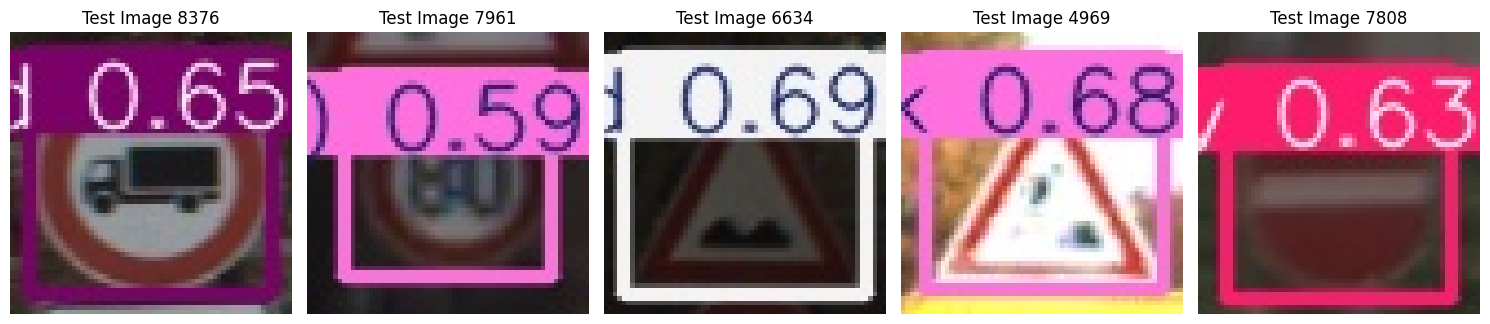

In [ ]:
import random

predictions_dir = "/kaggle/working/runs/detect/predict"
if os.path.exists(predictions_dir):
    shutil.rmtree(predictions_dir)  # Delete old predictions
    print("Deleted previous YOLO predictions.")

# Load X_test.npy
X_test = np.load("/kaggle/working/Checkpt_1/X_test.npy")

# Number of images to test
num_test_images = 5

# Randomly select test images
random_indices = random.sample(range(len(X_test)), num_test_images)

# Temporary folder for saving test images
temp_dir = "/kaggle/working/test_predictions"
os.makedirs(temp_dir, exist_ok=True)

# Run YOLO inference on randomly selected images
for i, idx in enumerate(random_indices):
    test_img = (X_test[idx] * 255).astype(np.uint8)

    # Save the image temporarily
    img_path = f"{temp_dir}/test_{i}.jpg"
    cv2.imwrite(img_path, cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR))

    # Run YOLO inference
    model.predict(source=img_path, save=True, conf=0.5)

    # Delete the temporary image after inference
    os.remove(img_path)

    print(f"Processed and deleted Image {i} (Index: {idx})")

# Get the latest predictions folder (should be "runs/detect/predict")
output_images = sorted(os.listdir(predictions_dir))[:num_test_images]  # Sorted to match order

# Display results
plt.figure(figsize=(15, 5))

for i, img_name in enumerate(output_images):
    output_path = os.path.join(predictions_dir, img_name)

    # Load the detected image
    output_image = cv2.imread(output_path)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    # Plot the image with a title showing the selected index
    plt.subplot(1, num_test_images, i + 1)
    plt.imshow(output_image)
    plt.title(f"Test Image {random_indices[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Model Evaluation

In [ ]:
yolo_predictions = []
for img in tqdm(X_test, desc="Testing Images"):
    img_path = "temp.jpg"
    cv2.imwrite(img_path, (img * 255).astype(np.uint8))
    results = model.predict(source=img_path, conf=0.5, verbose=False)
    yolo_predictions.append(results[0].boxes.cls[0].item() if results[0].boxes.cls.shape[0] > 0 else -1)

yolo_predictions = np.array(yolo_predictions)
np.save("yolo_predictions.npy", yolo_predictions)

Testing Images: 100%|██████████| 12630/12630 [01:41<00:00, 124.81it/s]


In [ ]:
accuracy = accuracy_score(y_test[yolo_predictions != -1], yolo_predictions[yolo_predictions != -1])
report = classification_report(y_test[yolo_predictions != -1], yolo_predictions[yolo_predictions != -1], digits=4)
print(f"Model Accuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:\n", report)


Model Accuracy: 98.24%

Classification Report:
               precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000        45
         1.0     0.9901    0.9986    0.9943       703
         2.0     0.9972    0.9958    0.9965       714
         3.0     0.9876    0.9900    0.9888       401
         4.0     1.0000    1.0000    1.0000       609
         5.0     0.9876    0.9982    0.9929       557
         6.0     1.0000    0.9620    0.9806        79
         7.0     1.0000    0.9976    0.9988       411
         8.0     0.9975    1.0000    0.9988       406
         9.0     0.9931    1.0000    0.9965       430
        10.0     1.0000    0.9751    0.9874       401
        11.0     0.9927    1.0000    0.9964       410
        12.0     0.9683    0.9857    0.9769       558
        13.0     1.0000    1.0000    1.0000       667
        14.0     0.7800    0.9286    0.8478        84
        15.0     1.0000    0.9890    0.9945       182
        16.0     1.0000    1.0000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
